## Libraries import

In [1]:
import os
import glob
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K


from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
csv_data = pd.read_csv(os.getcwd()+'/source_data/lgg-mri-segmentation/kaggle_3m/data.csv')
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
csv_data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [5]:
mask_files = glob.glob(os.getcwd()+"/source_data/lgg-mri-segmentation/kaggle_3m/*/*_mask*")
train_files = [file.replace('_mask', '') for file in mask_files]

In [6]:
# Parse each mask image with lambda function. Max value in mask img indicates abnormality
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'

    
df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "diagnosis":[diagnosis(x) for x in mask_files]})
df.head()

del mask_files, train_files  # Clean memory space

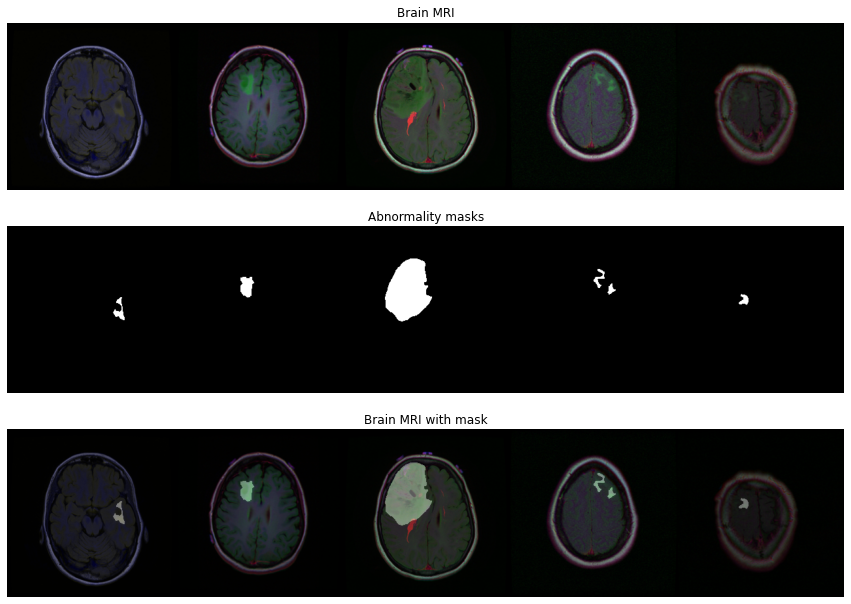

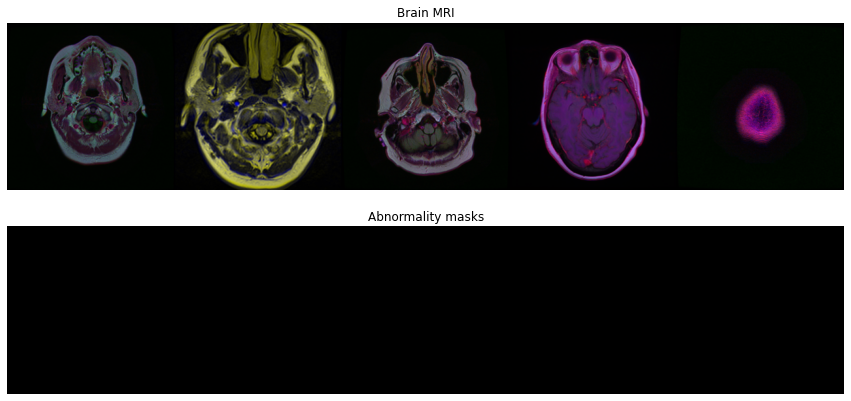

In [7]:
IMAGE_SIZE = (256, 256)

df_positive = df[df['diagnosis']=='1'].sample(5).values
df_negative = df[df['diagnosis']=='0'].sample(5).values

def show_data(df, positive=True):
    images = []
    masks = []
    for data in df:
        img = cv2.imread(data[0])
        mask = cv2.imread(data[1])
        images.append(img)
        masks.append(mask)
    images = np.hstack(np.array(images))
    masks = np.hstack(np.array(masks))
    
    fig = plt.figure(figsize=(15,15))
    if positive:
        grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.5)
    else:
        grid = ImageGrid(fig, 111, nrows_ncols=(2,1), axes_pad=0.5)
    grid[0].imshow(images)
    grid[0].set_title('Brain MRI', fontsize=12)
    grid[0].axis('off')
    grid[1].imshow(masks)
    grid[1].set_title('Abnormality masks', fontsize=12)
    grid[1].axis('off')
    if positive:
        grid[2].imshow(images)
        grid[2].imshow(masks, alpha=0.35)
        grid[2].set_title('Brain MRI with mask', fontsize=12)
        grid[2].axis('off')
        
show_data(df_positive)
show_data(df_negative, positive=False)

Split data into train/test

In [8]:
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2838, 3)
(501, 3)
(590, 3)


In [9]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [10]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    return - iou(y_true, y_pred)

In [11]:
# Set parameters
EPOCHS = 50
BATCH_SIZE = 16
learning_rate = 1e-4

In [12]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)

In [13]:
resnet50_model_extractor = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
resnet50_model_extractor.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [14]:
for layer in resnet50_model_extractor.layers:
    layer.trainable = False

In [15]:
def resnet50_model(input_size):
    resnet50_model = tf.keras.Sequential()
    resnet50_model.add(Input(input_size))
    resnet50_model.add(resnet50_model_extractor)
    # resnet50_model.add(Flatten())
    # resnet50_model.add(Dense(256, activation='relu'))
    # resnet50_model.add(Dropout(0.3))
    # resnet50_model.add(Dense(128, activation='relu'))
    # resnet50_model.add(Dropout(0.3))
    # resnet50_model.add(Dense(2, activation='relu'))
    return Model(inputs=[resnet50_model.input], outputs=[resnet50_model.output])

In [16]:
model = resnet50_model(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model.summary()


opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])


callbacks = [ModelCheckpoint('resnet50_brainMRI_seg.hdf5', verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, min_delta=0.0001, mode='min'),
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2838 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/50


InvalidArgumentError:  Incompatible shapes: [16,256,256,1] vs. [16,8,8,2048]
	 [[node bce_dice_loss/binary_crossentropy/logistic_loss/mul
 (defined at E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\backend.py:5158)
]] [Op:__inference_train_function_9899]

Errors may have originated from an input operation.
Input Source operations connected to node bce_dice_loss/binary_crossentropy/logistic_loss/mul:
In[0] model/resnet50/conv5_block3_out/Relu (defined at E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\backend.py:4867)	
In[1] IteratorGetNext (defined at E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\engine\training.py:866)

Operation defined at: (most recent call last)
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\rafal\AppData\Local\Temp\ipykernel_13484\2229894802.py", line 1, in <module>
>>>     history = model.fit(train_gen,
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\engine\training.py", line 809, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "C:\Users\rafal\AppData\Local\Temp\ipykernel_13484\127223837.py", line 15, in bce_dice_loss
>>>     return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\losses.py", line 1807, in binary_crossentropy
>>>     backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
>>> 
>>>   File "E:\projekty\Brain-MRI-Segmentation-Tensorflow\envconda_mri\lib\site-packages\keras\backend.py", line 5158, in binary_crossentropy
>>>     return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
>>> 

In [ ]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(model.history.history['loss'], 'b-', label='train_loss')
plt.plot(model.history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(model.history.history['iou'], 'b-', label='train_iou')
plt.plot(model.history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(model.history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(model.history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,IMAGE_SIZE)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()